# Classificação em Séries Temporais

Nome: Eder Gabriel da Trindade Félix NUSP: 9778515

Nome: Erica Mayumi Kanashiro NUSP: 9761698

Exercício de programação 2: Detecção de tendências em séries temporais utilizando redes complexas

In [1]:
import json
import pandas as pd
import seaborn as sns
from scipy.stats import norm as normal_dist
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import community

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

carregando limites de curto período e longo período

In [2]:
SHORT_TERM = 10
LONG_TERM = 50

In [3]:
smooth = False

O método é dividido em 7 etapas:
### 1. Obtenção e tratamento da série temporal

In [4]:
bvsp = pd.read_csv('./BVSP.csv')
bvsp['day'] = pd.to_datetime(bvsp.date, dayfirst=True)
bvsp = bvsp.drop(['date'], axis=1)
bvsp = bvsp.set_index('day')
bvsp = bvsp[~bvsp.close.isna()]

# Suavização
if smooth:
    bvsp = bvsp.rolling(5).close.mean()
    bvsp = pd.DataFrame({'close': bvsp[bvsp.index > '1995-01-01'].sort_index()})
else:
    # Tratar apenas dados pós Plano Real
    bvsp = pd.DataFrame(bvsp[bvsp.index > '1995-01-01'].sort_index())
bvsp.head()
# row = test

,close
day,
1995-01-02,4301.000000
1995-01-03,4098.000000
1995-01-04,3967.899902
1995-01-05,4036.699951
1995-01-06,3827.399902


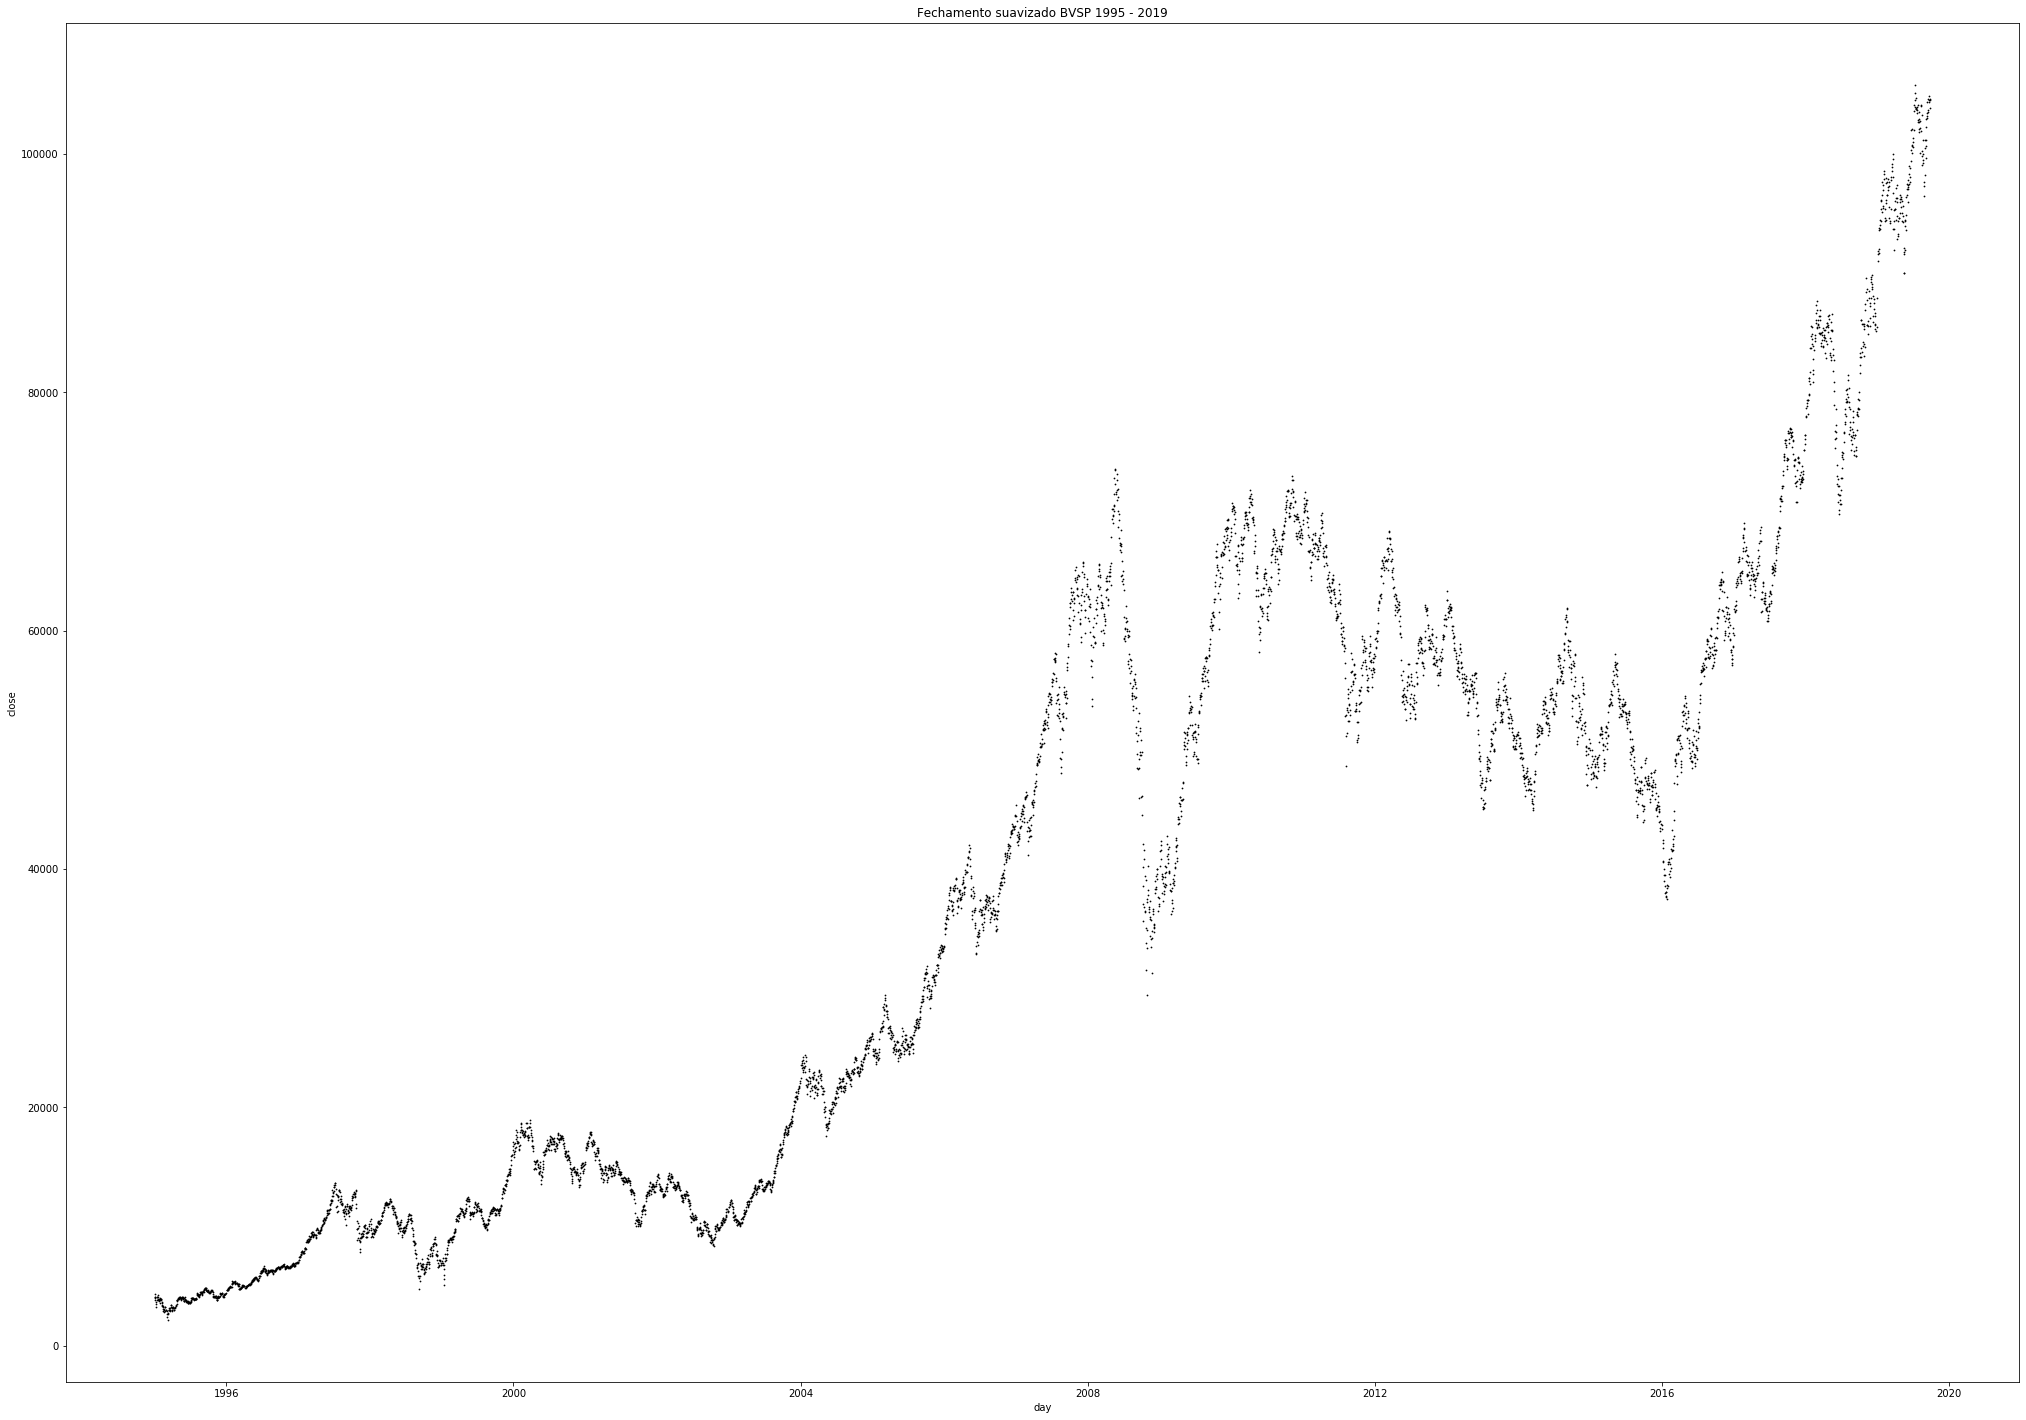

In [5]:
plt.figure(figsize=(35, 25))
sns.scatterplot(bvsp.index, bvsp.close, s=1, markers=['o'], color='black', edgecolor=None)
plt.title("Fechamento suavizado BVSP 1995 - 2019")
plt.savefig('plots/plain_all.png')

## 2. Calculando Features
Nesta etapa é processada a extração de características a partir da série temporal

In [6]:
bvsp = bvsp.assign(
    short_min = bvsp.rolling(SHORT_TERM).close.min(),
    short_max = bvsp.rolling(SHORT_TERM).close.max(),
    short_mean = bvsp.rolling(SHORT_TERM).close.mean(),
    
    long_min = bvsp.rolling(LONG_TERM).close.min(),
    long_max = bvsp.rolling(LONG_TERM).close.max(),
    long_mean = bvsp.rolling(LONG_TERM).close.mean()
)
bvsp = bvsp.assign(
    short_noise = (bvsp.close - bvsp.short_mean) / bvsp.short_mean,
    long_noise = (bvsp.close - bvsp.long_mean) / bvsp.long_mean,
)
bvsp = bvsp.assign(
    prev_short_mean = bvsp.short_mean.shift(),
    prev_long_mean = bvsp.long_mean.shift()
)
bvsp = bvsp.assign(
    short_gradient = (bvsp.short_mean - bvsp.prev_short_mean) / bvsp.prev_short_mean,
    long_gradient = (bvsp.long_mean - bvsp.prev_long_mean) / bvsp.prev_long_mean
)

bvsp = bvsp.assign(
    short_rel = (bvsp.close - bvsp.short_min) / (bvsp.short_max - bvsp.short_min),
    long_rel = (bvsp.close - bvsp.long_min) / (bvsp.long_max - bvsp.long_min)
)

In [7]:
df = bvsp[['short_noise', 'long_noise', 'short_gradient', 'long_gradient', 'short_rel', 'long_rel']][LONG_TERM + SHORT_TERM:]
df

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
day,,,,,,
1995-03-31,-0.048781,-0.089409,-0.000067,-0.006543,0.216846,0.405841
1995-04-03,-0.076771,-0.108369,0.000747,-0.008047,0.000000,0.389238
1995-04-04,-0.006646,-0.031310,0.003797,-0.005876,0.483709,0.532973
1995-04-05,0.005263,-0.010339,0.005607,-0.003900,0.598998,0.562787
1995-04-06,0.025216,0.016627,0.003445,-0.003782,0.754177,0.602917
...,...,...,...,...,...,...
2019-09-19,0.005547,0.022172,0.002024,-0.000158,0.834721,0.954386
2019-09-20,0.008325,0.026671,0.001814,0.000178,1.000000,1.000000
2019-09-23,0.005194,0.024751,0.001402,0.000164,0.899720,0.978657


### 2.1 Normalizando dados

Normalização pelo z-score

In [8]:
def F_norm(f):
    std_norm = (f - f.mean()) / f.std()
    return normal_dist.cdf(std_norm, loc=0, scale=1)

df_norm = df.apply(F_norm, axis=0)
df_norm

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
day,,,,,,
1995-03-31,0.053270,0.088329,0.455135,0.004638,0.178824,0.289633
1995-04-03,0.006389,0.055378,0.510270,0.000812,0.068181,0.273165
1995-04-04,0.383854,0.272794,0.706882,0.009198,0.413383,0.428300
1995-04-05,0.530817,0.368864,0.802916,0.051029,0.533469,0.462930
1995-04-06,0.758582,0.504677,0.685993,0.055711,0.688507,0.509941
...,...,...,...,...,...,...
2019-09-19,0.534355,0.533072,0.595942,0.394950,0.759034,0.855019
2019-09-20,0.568733,0.555996,0.582032,0.443009,0.872306,0.883429
2019-09-23,0.529961,0.546228,0.554493,0.440856,0.808925,0.870669


### 2.2 Discretização das colunas

In [9]:
def _discretize(x, reach, bins):
        for bi in bins[:-1]:
            if x < bi + reach: return bi
        
        return bins[-1]
    
def discretize(f, step, min=0, max=1):
    reach = step / 2
    bins = np.arange(min, max + step, step)
    return f.apply(lambda x: _discretize(x, reach, bins))

df_disc = df_norm.apply(lambda col: discretize(col, 0.15))
df_disc

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
day,,,,,,
1995-03-31,0.00,0.15,0.45,0.00,0.15,0.30
1995-04-03,0.00,0.00,0.45,0.00,0.00,0.30
1995-04-04,0.45,0.30,0.75,0.00,0.45,0.45
1995-04-05,0.60,0.30,0.75,0.00,0.60,0.45
1995-04-06,0.75,0.45,0.75,0.00,0.75,0.45
...,...,...,...,...,...,...
2019-09-19,0.60,0.60,0.60,0.45,0.75,0.90
2019-09-20,0.60,0.60,0.60,0.45,0.90,0.90
2019-09-23,0.60,0.60,0.60,0.45,0.75,0.90


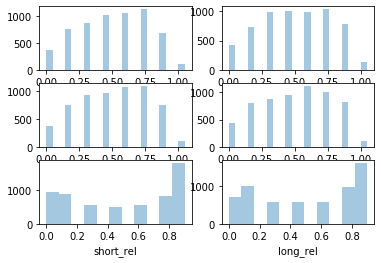

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=2)
sns.distplot(df_disc.short_noise, ax=axs[0][0], kde=False)
sns.distplot(df_disc.long_noise, ax=axs[0][1], kde=False)
sns.distplot(df_disc.short_gradient, ax=axs[1][0], kde=False)
sns.distplot(df_disc.long_gradient, ax=axs[1][1], kde=False)
sns.distplot(df_disc.short_rel, ax=axs[2][0], kde=False)
sns.distplot(df_disc.long_rel, ax=axs[2][1], kde=False)

## 3. Montagem do Grafo ( Rede )

Pegando nós únicos e gerando ids para eles

In [11]:
model_nodes = df_disc.drop_duplicates()
model_nodes = model_nodes.assign(
    node_id= range(1, len(model_nodes) + 1)
).set_index('node_id')
model_nodes

,short_noise,long_noise,short_gradient,long_gradient,short_rel,long_rel
node_id,,,,,,
1,0.00,0.15,0.45,0.00,0.15,0.30
2,0.00,0.00,0.45,0.00,0.00,0.30
3,0.45,0.30,0.75,0.00,0.45,0.45
4,0.60,0.30,0.75,0.00,0.60,0.45
5,0.75,0.45,0.75,0.00,0.75,0.45
...,...,...,...,...,...,...
2401,0.15,0.30,0.45,0.45,0.15,0.15
2402,0.45,0.30,0.45,0.30,0.60,0.30
2403,0.75,0.45,0.90,0.45,0.90,0.60


Atribuindo linhas de _df_disc_ para seus nós

In [12]:
df_with_ids = df_disc.merge(model_nodes.reset_index(),
                    on='short_noise long_noise short_gradient long_gradient short_rel long_rel'.split(),
                    right_index=True).sort_index()[['node_id']]
df_with_ids.head(5)

,node_id
day,
1995-03-31,1
1995-04-03,2
1995-04-04,3
1995-04-05,4
1995-04-06,5


In [13]:
# state_graph = pd.DataFrame(columns)
edges = df_with_ids[:-1].assign(
    source = df_with_ids[:-1].node_id,
    target = df_with_ids.shift(-1).dropna().astype(int)
)

edges = edges[['source', 'target']]

# remove self loops
edges = edges[edges.source != edges.target]

edges

,source,target
day,,
1995-03-31,1,2
1995-04-03,2,3
1995-04-04,3,4
1995-04-05,4,5
1995-04-06,5,6
...,...,...
2019-09-18,1886,297
2019-09-19,297,1886
2019-09-20,1886,297


In [14]:
nx_graph = nx.convert_matrix.from_pandas_edgelist(edges, source='source', target='target')

### 3.1 Visualização do grafo


In [15]:
with open('edges.js', 'w') as f:
    f.write('document.edges = ')
    f.write(edges.to_json(orient='records'))

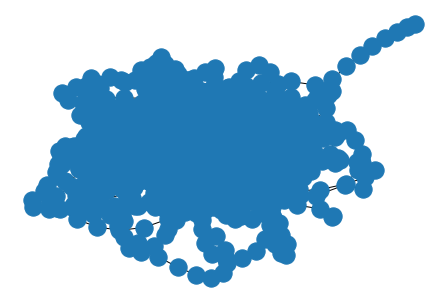

In [16]:
nx.draw(nx_graph)
plt.show()

![](./images/graph_2.png)


## 4. Detecção de comunidades

In [17]:
partition = community.best_partition(nx_graph)

comms = set(partition.values())
size = len(comms)
print(f'Detected {size} communities')

Detected 25 communities


In [ ]:
pos = nx.spring_layout(nx_graph)
count = 0

colormap = plt.cm.tab20(range(0, size))
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes( nx_graph, pos, list_nodes, node_size = 20,
                            node_color = [colormap[count]])
    count = count + 1
    
nx.draw_networkx_edges(nx_graph, pos, alpha=0.5)
plt.show()

In [ ]:
with open('partitions.js', 'w') as f:
    f.write('document.partitions = ' + json.dumps(partition))

In [ ]:
node_ids, partition_ids = zip(*partition.items())
partition_df = pd.DataFrame({
    'node_id': node_ids,
    'partition': partition_ids
})
partition_df = partition_df.set_index('node_id')[['partition']]
partition_df

In [ ]:
bvsp_with_partitions = df_with_ids\
                        .merge(partition_df, left_on='node_id', right_index=True)\
                        .merge(bvsp, left_index=True, right_index=True, how='inner')

bvsp_with_partitions = bvsp_with_partitions[['close', 'node_id', 'partition']]\
    .sort_index()

bvsp_with_partitions

### 4.1 Série histórica com partições

#### Dataset inteiro

In [ ]:
palette=sns.color_palette('Paired', n_colors=bvsp_with_partitions.partition.unique().size)
plt.figure(figsize=(35, 25))
ax = plt.subplot()
sns.scatterplot(x='day', y='close', data=bvsp_with_partitions.reset_index(),
                hue='partition', palette=palette,
                s=20, markers=['o'], edgecolor=None, legend=False)
plt.title('Histórico completo, particionado')

plt.savefig('plots/partitions_all.png')

#### Últimos 730 dias

In [ ]:
t = bvsp_with_partitions.iloc[-730:].reset_index()
palette=sns.color_palette('Paired', n_colors=t.partition.unique().size)
plt.figure(figsize=(35, 25))
ax = plt.subplot()
sns.scatterplot(x='day', y='close', data=t,
                hue='partition', palette=palette,
                s=20, markers=['o'], edgecolor=None, legend=False)
plt.title('Últimos 730 dias, particionado')
ax.set_xlim(t.day.min(), t.day.max())
plt.savefig('plots/partitions_720.png')

## 5. Rotulagem de Tendências

In [ ]:
partition_labels = pd.DataFrame({
    'partition': bvsp_with_partitions.partition,
    'delta_score': bvsp_with_partitions.close.rolling(2).apply(lambda x: (x[1] / x[0]))
})[1:]


partition_labels = partition_labels.groupby('partition').agg({
    'delta_score': 'mean'
})

# partition_labels = bvsp_with_partitions\
#     .groupby(['partition', 'ocurrence_label']).agg(
#         delta_score=('close', get_delta_score)
#     )\
#     .dropna()\
#     .groupby(['partition']).agg(
#         delta_score = ('delta_score', 'mean'),
#     )
partition_labels

### 5.1 Quantis do delta score

In [ ]:
for i in np.arange(0, 1, 0.05):
    print('q', "%.2f" % round(i,2), ':' ,partition_labels.delta_score.quantile(i))

### 5.2 Discretização / Criação das labels

In [ ]:

partition_labels['partition_label'] = 'unknown'
d = 0.0000
partition_labels.loc[partition_labels['delta_score'] > 1. + d, 'partition_label'] = 'up'
partition_labels.loc[partition_labels['delta_score'] < 1. - d, 'partition_label'] = 'down'
partition_labels

In [ ]:
partition_labels.partition_label.value_counts()

In [ ]:
bvsp_labeled = bvsp_with_partitions.reset_index().merge(partition_labels, on='partition', left_index=True)
bvsp_labeled = bvsp_labeled['day close delta_score partition_label'.split()].set_index('day').sort_index()
bvsp_labeled

In [ ]:
bvsp_labeled.partition_label.value_counts()

#### Plot completo pré discretização de label

In [ ]:
t = bvsp_labeled
#palette= sns.color_palette('Blues', n_colors=t.delta_score.unique().size)
palette = sns.diverging_palette(240, 10, n=t.delta_score.unique().size)
plt.figure(figsize=(35, 25))
sns.scatterplot(x='day', y='close', data=t.reset_index(),
                hue='delta_score', palette=palette,
                s=20, markers=['o'], edgecolor=None, legend='full')

plt.title('Histórico completo, por delta-s')
plt.savefig('plots/delta_score_all.png')

#### Plot completo pós discretização de label

In [ ]:
t = bvsp_labeled#.sample(frac=1)
palette={
    'up': 'red',
    'down': 'blue',
    'unknown': 'gray'
}
plt.figure(figsize=(35, 25))
sns.scatterplot(x='day', y='close', data=t.reset_index(),
                hue='partition_label', palette=palette,
                s=17, markers=['o'], edgecolor=None, legend='full')

plt.title('Histórico completo, classificado')
plt.savefig('plots/classified_all.png')

#### Plot 720 dias pré discretização de label

In [ ]:
t = bvsp_labeled.iloc[-720:].reset_index()
palette = sns.diverging_palette(240, 10, n=t.delta_score.unique().size)
plt.figure(figsize=(35, 25))
ax = plt.subplot()
sns.scatterplot(x='day', y='close', data=t,
                hue='delta_score', palette=palette,
                s=25, markers=['o'], edgecolor=None, legend='full')

ax.set_xlim(t.day.min(), t.day.max())
plt.title('Histórico completo, classificado')
plt.savefig('plots/classified_720.png')


In [ ]:
t = bvsp_labeled.iloc[-720:].reset_index()
palette={
    'up': 'red',
    'down': 'blue',
    'unknown': 'gray'
}
plt.figure(figsize=(35, 25))
ax = plt.subplot()
sns.scatterplot(x='day', y='close', data=t,
                hue='partition_label', palette=palette,
                s=25, markers=['o'], edgecolor=None, legend='full')

ax.set_xlim(t.day.min(), t.day.max())
plt.title('Histórico completo, classificado')
plt.savefig('plots/classified_720.png')


### Salvando dados  - Matriz de características

Salvando csv com...
  - Dias e seus fechamentos
  - Features de cada dia
  - Respectivos delta_score e partition_labels da respectiva partição

In [ ]:
t = bvsp_labeled\
    .merge(df, left_index=True, right_index=True)\
    .sort_index()['close short_noise long_noise short_gradient long_gradient short_rel long_rel delta_score partition_label'.split()]
if smooth:
    t.to_csv('bvsp_labeled.csv')
else:
    t.to_csv('bvsp_labeled_nonsmoothed.csv')
t

In [ ]:
q = pd.DataFrame({
    'close': bvsp_labeled.close,
    'delta_score': bvsp_labeled.close.rolling(2).apply(lambda x: (x[1] / x[0]))
})[1:]
q

In [ ]:
palette = sns.diverging_palette(240, 10, n=q.delta_score.unique().size)
t = q.reset_index()

plt.figure(figsize=(35, 25))
ax = plt.subplot()
sns.scatterplot(x='day', y='close', data=t,
                hue='delta_score', palette=palette,
                s=25, markers=['o'], edgecolor=None, legend=None)

ax.set_xlim(t.day.min(), t.day.max())
# plt.title('Histórico completo, classificado')
# plt.savefig('plots/classified_720.png')

## 6. Previsão de tendência

### Avaliação de desempenho

## Testes